# Модель, распознающая загрязнённый текст

# Описание задачи и исследования

<b>Задача от ЦРТ:</b><br> Создать модель, которая будет распознавать, загрязнённый текст или нет. Данный текст используется для обучения и тестирования системы расстановки знаков препинания и капитализации.

Для реальной задачи использовались тексты, с которыми работал ЦРТ, однако в данном случае мы будем использовать датасет <a href="https://tatianashavrina.github.io/taiga_site/downloads">тайга</a>.

Задача окажется решённой, если будет создана модель, которая сможет сортировать грязный текст и чистый.

<b>Решение</b><br>
В нашем исследовании мы проверим два способа:
- с учётом лексем
- без учёта лексем

В первом случае будем использовать токенизацию через многоязычный берт и алгоритм tf-idf, во втором случае мы будем создавать статистические табличные данные и тестировать модель на них. Также будут исследованы следующие подходы:
- классификация
- кластеризация

# Загрузка данных

## Загрузка датасета

In [54]:
import pandas as pd
import os
from tqdm import tqdm

In [55]:
way = "C:/Users/Dmitri/Downloads/home/tsha/NPlus1/texts"
content = os.listdir(way)

In [3]:
text = ''
for i in tqdm(content):
    with open(way+'/'+i, 'r', encoding='utf-8') as file:
        sub = file.read()
    text += sub + '\n'

100%|█████████████████████████████████████████████████████████████████████████████| 7696/7696 [01:05<00:00, 117.76it/s]


In [4]:
len(text)

14375888

## Загрязнение датасета

Так как изначально у нас нет загрязнённых данных, мы их синтезируем:
- лишние пробелы
- удаление пробелов
- добавление лишних знаков препинания
- добавление лишних символов
- изменение капитализации

Синтез данных поможет сделать равномерное распределение классов. 

In [5]:
from random import choice, randint
from tqdm import tqdm

# добавление пробелов вероятность 1/4
def addspace(string):
    new = ''
    for i in string:
        if choice([True, False, False, False]):
            new+=' '
        new+=i
    return new

# удаление пробелов 1/2
def delspace(string):
    new = ''
    for i in string:
        if i == ' ' and choice([True, False]):
            pass
        else:
            new+=i
    return new

# добавление знаков препинания после слов 1/3
def punkt(string):
    new = ''
    last = ''
    for i in string:
        if (last.isalpha() or last.isdigit()) and i == ' ' and choice([True, False, False]):
            new+=choice([',', '.', '!', "''", '?', ':', ';'])
        new+=i
    return new

# добавление лишних символов 1/5
def addsumbol(string):
    new = ''
    for i in string:
        if choice([True, False, False, False, False]):
            new+=choice(['1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '@', '#', '$', '%', '^', '&', '*', '(', ')', '+',
                        '=', '№', '~', '`'])
        new+=i
    return new

# изменение капитализации 1/3
def cap(string):
    new = ''
    for i in string:
        if choice([True, False, False]) and i.isalpha():
            new+=i.swapcase()
        else:
            new+=i
    return new


def rubish(text, func=[cap, addsumbol, punkt, delspace, addspace]):
    rtext = ''
    for string in tqdm(text.split('\n')):
        list_func = []
        for i in range(randint(0, len(func))):
            list_func.append(choice(func))
        for fun in list_func:
            string = fun(string)
        rtext+=string+'\n'
    return rtext

In [6]:
bad = rubish(text)

100%|███████████████████████████████████████████████████████████████████████████| 86301/86301 [02:59<00:00, 481.91it/s]


In [7]:
data = []
for string in text.split('\n'):
    if len(string)>0:
        data.append([string, 1])
for string in bad.split('\n'):
    if len(string)>0:
        data.append([string, 0])

In [8]:
data = pd.DataFrame(data, columns=['string', 'mark'])
data

,string,mark
0,Сотрудники Венского медицинского университета ...,1
1,Ученые из Университета Сапиенца в Риме предлож...,1
2,Сотрудники Массачусетского технологического ин...,1
3,Американо-немецкая группа исследователей обнар...,1
4,Крупная международная коллаборация исследовате...,1
...,...,...
141447,Американская к7омпания@S^ier`r5aNevad&aпередал...,0
141448,Во зду шн*о0-космичес к6 ие& си&лы Ро0^с 8 с&...,0
141449,6РоссИЙс&к*аЯ сИСтЕ&м3а ПРоТИВоРа0к2ЕтнОй ОБОР...,0
141450,Американский автомобильный концернFordразработ...,0


In [9]:
data.to_csv(r"C:\Users\Dmitri\Downloads\NLP\the_data.csv")

# Решение с учётом лексического содержания

## Импорт

In [209]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from tqdm import tqdm
RANDOM_STATE = 101
from sklearn.ensemble import RandomForestClassifier
#from imblearn.pipeline import Pipeline, make_pipeline
#from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import roc_curve
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold
from sklearn.metrics import roc_auc_score, auc
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error 
from sklearn.dummy import DummyClassifier
#pd.options.mode.chained_assignment = None
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, precision_recall_curve, classification_report

## Работа с данными

In [210]:
data = pd.read_csv(r"C:\Users\Dmitri\Downloads\NLP\the_data.csv")[['string', 'mark']]

In [211]:
data['mark'].value_counts()

1    70844
0    70608
Name: mark, dtype: int64

Так как у нас ограниченное количество памяти, то для эксперимента мы возьмём 10000 примеров.

In [52]:
X_good = data[data['mark'] == 1][:5000]

In [53]:
X_bad = data[data['mark'] == 0][:5000]

In [54]:
data = pd.concat([X_good, X_bad])

In [55]:
data['mark'].value_counts()

1    5000
0    5000
Name: mark, dtype: int64

In [56]:
X = data['string']
y = data['mark'].astype(int)

In [193]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=RANDOM_STATE)

<Axes: ylabel='mark'>

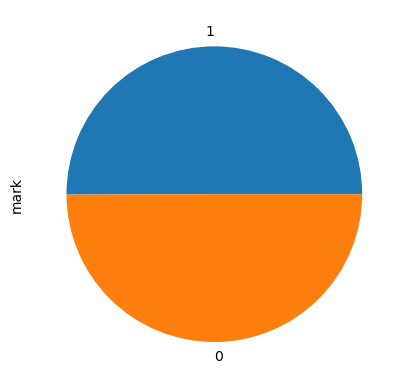

In [10]:
y_train.value_counts().plot(kind='pie')

<Axes: ylabel='mark'>

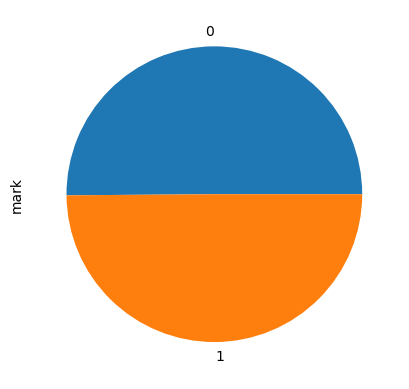

In [11]:
y_test.value_counts().plot(kind='pie')

## tf-idf

### Векторизация

In [194]:
%%time
vectorizer = TfidfVectorizer() 
vectorizer.fit(X_train)

CPU times: total: 172 ms
Wall time: 189 ms


TfidfVectorizer()

In [195]:
def tf(text, vectorizer=vectorizer, fit=False):
    if type(text) == str:
        text = text.split("\n")
    if fit==True:
        tfidf_matrix = vectorizer.fit_transform(text)
    else:
        tfidf_matrix = vectorizer.transform(text)
    return tfidf_matrix.toarray().astype(np.float16)

In [196]:
%%time
tf('Здесь будет предложение')

CPU times: total: 0 ns
Wall time: 3.52 ms


array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float16)

### Подготовка данных

In [14]:
X_test

72520            Ученые  с чит ают, что ,  нес мотр я  н а
72265                                      на сайте Фонда.
75678    вырубки лесов человеком и особенностей своего ...
74336    тЕряют 4маСсУ в хОде СВ№оЕй~ эВо2л9ю0ции. Р^аБ...
75826    +Ле`ЧеНИяисп%о6ЛьЗ$Ую`тсяэл$е7кт9Ро*д~ы-им0пЛа...
                               ...                        
74943                                    И с следоват ел и
71114                                               \t<!--
71488    \t\tp   { maRGIn-Botto m :  0.2 5cm; liNE -HEi...
72204              от нескольких дней до полугода, а время
75541                                           оБ ы0+ чнО
Name: string, Length: 2500, dtype: object

In [15]:
X_train_tf = tf(X_train)
X_test_tf = tf(X_test)

### Обучение

In [146]:
import time

def measure_time(func, *args, **kwargs):
    start_time = time.time()
    func(*args, **kwargs)
    end_time = time.time()
    return round(end_time - start_time, 4)

In [17]:
results_1 = [['type', 'name', 'F1', 'roc_auc', 'time.fit', 'time.pred']]

#### Регрессия

In [18]:
log1 = LogisticRegression(random_state=RANDOM_STATE)

In [19]:
log1.fit(X_train_tf, y_train)

LogisticRegression(random_state=101)

In [20]:
log_pred1 = log1.predict(X_test_tf)

In [21]:
print(classification_report(y_test, log_pred1))

              precision    recall  f1-score   support

           0       0.67      0.61      0.64      1253
           1       0.64      0.70      0.67      1247

    accuracy                           0.65      2500
   macro avg       0.65      0.65      0.65      2500
weighted avg       0.65      0.65      0.65      2500



In [22]:
results_1.append(['tf-idf', 
                  'log', 
                  round(f1_score(y_test, log_pred1), 4), 
                  round(roc_auc_score(y_test, log_pred1), 4), 
                  measure_time(log1.fit, X_train_tf, y_train),
                  measure_time(log1.predict, X_test_tf)])

#### Лес

In [23]:
rf1 = RandomForestClassifier(random_state=RANDOM_STATE)

In [24]:
rf1.fit(X_train_tf, y_train)

RandomForestClassifier(random_state=101)

In [25]:
rf_pred1 = rf1.predict(X_test_tf)

In [26]:
results_1.append(['tf-idf', 
                  'forest', 
                  round(f1_score(y_test, rf_pred1), 4), 
                  round(roc_auc_score(y_test, rf_pred1), 4), 
                  measure_time(rf1.fit, X_train_tf, y_train),
                  measure_time(rf1.predict, X_test_tf)])

#### CatBoost

In [27]:
cat1 = CatBoostClassifier(random_state=RANDOM_STATE)

In [28]:
cat1.fit(X_train_tf, y_train)

Learning rate set to 0.024355
0:	learn: 0.6894682	total: 470ms	remaining: 7m 49s
1:	learn: 0.6860688	total: 729ms	remaining: 6m 3s
2:	learn: 0.6829799	total: 972ms	remaining: 5m 23s
3:	learn: 0.6800919	total: 1.17s	remaining: 4m 50s
4:	learn: 0.6770040	total: 1.35s	remaining: 4m 28s
5:	learn: 0.6740790	total: 1.55s	remaining: 4m 16s
6:	learn: 0.6713724	total: 1.74s	remaining: 4m 6s
7:	learn: 0.6688922	total: 1.96s	remaining: 4m 3s
8:	learn: 0.6663741	total: 2.13s	remaining: 3m 54s
9:	learn: 0.6636674	total: 2.3s	remaining: 3m 47s
10:	learn: 0.6614535	total: 2.49s	remaining: 3m 44s
11:	learn: 0.6593065	total: 2.69s	remaining: 3m 41s
12:	learn: 0.6570210	total: 2.87s	remaining: 3m 38s
13:	learn: 0.6550901	total: 3.07s	remaining: 3m 36s
14:	learn: 0.6533979	total: 3.25s	remaining: 3m 33s
15:	learn: 0.6518084	total: 3.45s	remaining: 3m 32s
16:	learn: 0.6502057	total: 3.62s	remaining: 3m 29s
17:	learn: 0.6483660	total: 3.8s	remaining: 3m 27s
18:	learn: 0.6465672	total: 3.98s	remaining: 3m 2

159:	learn: 0.5777741	total: 32.7s	remaining: 2m 51s
160:	learn: 0.5775671	total: 33s	remaining: 2m 51s
161:	learn: 0.5773368	total: 33.1s	remaining: 2m 51s
162:	learn: 0.5772031	total: 33.4s	remaining: 2m 51s
163:	learn: 0.5769904	total: 33.6s	remaining: 2m 51s
164:	learn: 0.5767727	total: 33.8s	remaining: 2m 51s
165:	learn: 0.5766730	total: 34s	remaining: 2m 50s
166:	learn: 0.5762180	total: 34.2s	remaining: 2m 50s
167:	learn: 0.5759273	total: 34.4s	remaining: 2m 50s
168:	learn: 0.5756509	total: 34.5s	remaining: 2m 49s
169:	learn: 0.5754682	total: 34.8s	remaining: 2m 49s
170:	learn: 0.5751805	total: 34.9s	remaining: 2m 49s
171:	learn: 0.5750184	total: 35.1s	remaining: 2m 49s
172:	learn: 0.5748159	total: 35.4s	remaining: 2m 49s
173:	learn: 0.5746404	total: 35.6s	remaining: 2m 48s
174:	learn: 0.5744604	total: 35.8s	remaining: 2m 48s
175:	learn: 0.5743227	total: 36s	remaining: 2m 48s
176:	learn: 0.5742031	total: 36.2s	remaining: 2m 48s
177:	learn: 0.5740294	total: 36.4s	remaining: 2m 48s

315:	learn: 0.5524078	total: 1m 3s	remaining: 2m 17s
316:	learn: 0.5522650	total: 1m 3s	remaining: 2m 17s
317:	learn: 0.5521355	total: 1m 4s	remaining: 2m 17s
318:	learn: 0.5520103	total: 1m 4s	remaining: 2m 17s
319:	learn: 0.5518422	total: 1m 4s	remaining: 2m 16s
320:	learn: 0.5517570	total: 1m 4s	remaining: 2m 16s
321:	learn: 0.5516333	total: 1m 4s	remaining: 2m 16s
322:	learn: 0.5514590	total: 1m 4s	remaining: 2m 16s
323:	learn: 0.5513165	total: 1m 5s	remaining: 2m 15s
324:	learn: 0.5512490	total: 1m 5s	remaining: 2m 15s
325:	learn: 0.5511664	total: 1m 5s	remaining: 2m 15s
326:	learn: 0.5510842	total: 1m 5s	remaining: 2m 14s
327:	learn: 0.5509510	total: 1m 5s	remaining: 2m 14s
328:	learn: 0.5508404	total: 1m 5s	remaining: 2m 14s
329:	learn: 0.5507512	total: 1m 6s	remaining: 2m 14s
330:	learn: 0.5506096	total: 1m 6s	remaining: 2m 13s
331:	learn: 0.5504767	total: 1m 6s	remaining: 2m 13s
332:	learn: 0.5503196	total: 1m 6s	remaining: 2m 13s
333:	learn: 0.5501337	total: 1m 6s	remaining: 

469:	learn: 0.5339805	total: 1m 34s	remaining: 1m 46s
470:	learn: 0.5338576	total: 1m 34s	remaining: 1m 46s
471:	learn: 0.5337156	total: 1m 34s	remaining: 1m 46s
472:	learn: 0.5335980	total: 1m 34s	remaining: 1m 45s
473:	learn: 0.5334399	total: 1m 35s	remaining: 1m 45s
474:	learn: 0.5332700	total: 1m 35s	remaining: 1m 45s
475:	learn: 0.5332290	total: 1m 35s	remaining: 1m 45s
476:	learn: 0.5331608	total: 1m 35s	remaining: 1m 45s
477:	learn: 0.5331285	total: 1m 35s	remaining: 1m 44s
478:	learn: 0.5330785	total: 1m 36s	remaining: 1m 44s
479:	learn: 0.5330227	total: 1m 36s	remaining: 1m 44s
480:	learn: 0.5329323	total: 1m 36s	remaining: 1m 44s
481:	learn: 0.5328127	total: 1m 36s	remaining: 1m 44s
482:	learn: 0.5327099	total: 1m 36s	remaining: 1m 43s
483:	learn: 0.5325516	total: 1m 37s	remaining: 1m 43s
484:	learn: 0.5325120	total: 1m 37s	remaining: 1m 43s
485:	learn: 0.5323936	total: 1m 37s	remaining: 1m 43s
486:	learn: 0.5323430	total: 1m 37s	remaining: 1m 42s
487:	learn: 0.5323074	total:

622:	learn: 0.5215702	total: 2m 5s	remaining: 1m 15s
623:	learn: 0.5214536	total: 2m 5s	remaining: 1m 15s
624:	learn: 0.5213934	total: 2m 5s	remaining: 1m 15s
625:	learn: 0.5212988	total: 2m 5s	remaining: 1m 15s
626:	learn: 0.5211636	total: 2m 6s	remaining: 1m 15s
627:	learn: 0.5210451	total: 2m 6s	remaining: 1m 14s
628:	learn: 0.5208988	total: 2m 6s	remaining: 1m 14s
629:	learn: 0.5208108	total: 2m 6s	remaining: 1m 14s
630:	learn: 0.5207019	total: 2m 6s	remaining: 1m 14s
631:	learn: 0.5205949	total: 2m 7s	remaining: 1m 14s
632:	learn: 0.5205314	total: 2m 7s	remaining: 1m 13s
633:	learn: 0.5205127	total: 2m 7s	remaining: 1m 13s
634:	learn: 0.5204198	total: 2m 7s	remaining: 1m 13s
635:	learn: 0.5202806	total: 2m 8s	remaining: 1m 13s
636:	learn: 0.5202654	total: 2m 8s	remaining: 1m 13s
637:	learn: 0.5202425	total: 2m 8s	remaining: 1m 12s
638:	learn: 0.5200671	total: 2m 8s	remaining: 1m 12s
639:	learn: 0.5200455	total: 2m 8s	remaining: 1m 12s
640:	learn: 0.5200275	total: 2m 9s	remaining: 

778:	learn: 0.5095856	total: 2m 36s	remaining: 44.4s
779:	learn: 0.5094777	total: 2m 36s	remaining: 44.3s
780:	learn: 0.5094573	total: 2m 37s	remaining: 44s
781:	learn: 0.5092980	total: 2m 37s	remaining: 43.8s
782:	learn: 0.5091959	total: 2m 37s	remaining: 43.7s
783:	learn: 0.5090703	total: 2m 37s	remaining: 43.5s
784:	learn: 0.5089519	total: 2m 37s	remaining: 43.2s
785:	learn: 0.5088165	total: 2m 38s	remaining: 43s
786:	learn: 0.5087985	total: 2m 38s	remaining: 42.8s
787:	learn: 0.5087571	total: 2m 38s	remaining: 42.6s
788:	learn: 0.5087411	total: 2m 38s	remaining: 42.4s
789:	learn: 0.5087154	total: 2m 38s	remaining: 42.2s
790:	learn: 0.5085925	total: 2m 38s	remaining: 42s
791:	learn: 0.5085752	total: 2m 39s	remaining: 41.8s
792:	learn: 0.5084838	total: 2m 39s	remaining: 41.6s
793:	learn: 0.5083715	total: 2m 39s	remaining: 41.4s
794:	learn: 0.5082847	total: 2m 39s	remaining: 41.2s
795:	learn: 0.5081958	total: 2m 39s	remaining: 41s
796:	learn: 0.5080984	total: 2m 40s	remaining: 40.8s
7

935:	learn: 0.4987183	total: 3m 7s	remaining: 12.8s
936:	learn: 0.4986952	total: 3m 8s	remaining: 12.6s
937:	learn: 0.4986080	total: 3m 8s	remaining: 12.4s
938:	learn: 0.4985730	total: 3m 8s	remaining: 12.2s
939:	learn: 0.4984847	total: 3m 8s	remaining: 12s
940:	learn: 0.4984674	total: 3m 8s	remaining: 11.8s
941:	learn: 0.4984487	total: 3m 9s	remaining: 11.6s
942:	learn: 0.4983776	total: 3m 9s	remaining: 11.4s
943:	learn: 0.4983663	total: 3m 9s	remaining: 11.2s
944:	learn: 0.4983527	total: 3m 9s	remaining: 11s
945:	learn: 0.4982909	total: 3m 9s	remaining: 10.8s
946:	learn: 0.4982247	total: 3m 10s	remaining: 10.6s
947:	learn: 0.4982076	total: 3m 10s	remaining: 10.4s
948:	learn: 0.4981032	total: 3m 10s	remaining: 10.2s
949:	learn: 0.4980038	total: 3m 10s	remaining: 10s
950:	learn: 0.4979872	total: 3m 10s	remaining: 9.83s
951:	learn: 0.4979174	total: 3m 11s	remaining: 9.63s
952:	learn: 0.4978654	total: 3m 11s	remaining: 9.43s
953:	learn: 0.4977944	total: 3m 11s	remaining: 9.23s
954:	learn

In [29]:
cat_pred1 = cat1.predict(X_test_tf)

In [30]:
results_1.append(['tf-idf', 
                  'cat', 
                  round(f1_score(y_test, cat_pred1), 4), 
                  round(roc_auc_score(y_test, cat_pred1), 4), 
                  measure_time(cat1.fit, X_train_tf, y_train),
                  measure_time(cat1.predict, X_test_tf)])

Learning rate set to 0.024355
0:	learn: 0.6894682	total: 244ms	remaining: 4m 3s
1:	learn: 0.6860688	total: 493ms	remaining: 4m 5s
2:	learn: 0.6829799	total: 716ms	remaining: 3m 58s
3:	learn: 0.6800919	total: 988ms	remaining: 4m 6s
4:	learn: 0.6770040	total: 1.23s	remaining: 4m 4s
5:	learn: 0.6740790	total: 1.43s	remaining: 3m 56s
6:	learn: 0.6713724	total: 1.63s	remaining: 3m 51s
7:	learn: 0.6688922	total: 1.85s	remaining: 3m 49s
8:	learn: 0.6663741	total: 2.05s	remaining: 3m 46s
9:	learn: 0.6636674	total: 2.3s	remaining: 3m 47s
10:	learn: 0.6614535	total: 2.48s	remaining: 3m 42s
11:	learn: 0.6593065	total: 2.69s	remaining: 3m 41s
12:	learn: 0.6570210	total: 2.89s	remaining: 3m 39s
13:	learn: 0.6550901	total: 3.08s	remaining: 3m 36s
14:	learn: 0.6533979	total: 3.26s	remaining: 3m 33s
15:	learn: 0.6518084	total: 3.44s	remaining: 3m 31s
16:	learn: 0.6502057	total: 3.62s	remaining: 3m 29s
17:	learn: 0.6483660	total: 3.81s	remaining: 3m 27s
18:	learn: 0.6465672	total: 3.97s	remaining: 3m 2

159:	learn: 0.5777741	total: 32s	remaining: 2m 48s
160:	learn: 0.5775671	total: 32.2s	remaining: 2m 47s
161:	learn: 0.5773368	total: 32.4s	remaining: 2m 47s
162:	learn: 0.5772031	total: 32.6s	remaining: 2m 47s
163:	learn: 0.5769904	total: 32.8s	remaining: 2m 47s
164:	learn: 0.5767727	total: 33s	remaining: 2m 47s
165:	learn: 0.5766730	total: 33.3s	remaining: 2m 47s
166:	learn: 0.5762180	total: 33.5s	remaining: 2m 46s
167:	learn: 0.5759273	total: 33.7s	remaining: 2m 46s
168:	learn: 0.5756509	total: 33.9s	remaining: 2m 46s
169:	learn: 0.5754682	total: 34.1s	remaining: 2m 46s
170:	learn: 0.5751805	total: 34.3s	remaining: 2m 46s
171:	learn: 0.5750184	total: 34.4s	remaining: 2m 45s
172:	learn: 0.5748159	total: 34.6s	remaining: 2m 45s
173:	learn: 0.5746404	total: 34.8s	remaining: 2m 45s
174:	learn: 0.5744604	total: 35.1s	remaining: 2m 45s
175:	learn: 0.5743227	total: 35.3s	remaining: 2m 45s
176:	learn: 0.5742031	total: 35.5s	remaining: 2m 45s
177:	learn: 0.5740294	total: 35.8s	remaining: 2m 4

316:	learn: 0.5522650	total: 1m 4s	remaining: 2m 17s
317:	learn: 0.5521355	total: 1m 4s	remaining: 2m 17s
318:	learn: 0.5520103	total: 1m 4s	remaining: 2m 17s
319:	learn: 0.5518422	total: 1m 4s	remaining: 2m 17s
320:	learn: 0.5517570	total: 1m 4s	remaining: 2m 16s
321:	learn: 0.5516333	total: 1m 5s	remaining: 2m 16s
322:	learn: 0.5514590	total: 1m 5s	remaining: 2m 16s
323:	learn: 0.5513165	total: 1m 5s	remaining: 2m 16s
324:	learn: 0.5512490	total: 1m 5s	remaining: 2m 16s
325:	learn: 0.5511664	total: 1m 5s	remaining: 2m 16s
326:	learn: 0.5510842	total: 1m 6s	remaining: 2m 15s
327:	learn: 0.5509510	total: 1m 6s	remaining: 2m 15s
328:	learn: 0.5508404	total: 1m 6s	remaining: 2m 15s
329:	learn: 0.5507512	total: 1m 6s	remaining: 2m 15s
330:	learn: 0.5506096	total: 1m 6s	remaining: 2m 15s
331:	learn: 0.5504767	total: 1m 7s	remaining: 2m 15s
332:	learn: 0.5503196	total: 1m 7s	remaining: 2m 14s
333:	learn: 0.5501337	total: 1m 7s	remaining: 2m 14s
334:	learn: 0.5500278	total: 1m 7s	remaining: 

471:	learn: 0.5337156	total: 1m 35s	remaining: 1m 47s
472:	learn: 0.5335980	total: 1m 36s	remaining: 1m 47s
473:	learn: 0.5334399	total: 1m 36s	remaining: 1m 46s
474:	learn: 0.5332700	total: 1m 36s	remaining: 1m 46s
475:	learn: 0.5332290	total: 1m 36s	remaining: 1m 46s
476:	learn: 0.5331608	total: 1m 36s	remaining: 1m 46s
477:	learn: 0.5331285	total: 1m 37s	remaining: 1m 46s
478:	learn: 0.5330785	total: 1m 37s	remaining: 1m 45s
479:	learn: 0.5330227	total: 1m 37s	remaining: 1m 45s
480:	learn: 0.5329323	total: 1m 37s	remaining: 1m 45s
481:	learn: 0.5328127	total: 1m 37s	remaining: 1m 45s
482:	learn: 0.5327099	total: 1m 38s	remaining: 1m 45s
483:	learn: 0.5325516	total: 1m 38s	remaining: 1m 44s
484:	learn: 0.5325120	total: 1m 38s	remaining: 1m 44s
485:	learn: 0.5323936	total: 1m 38s	remaining: 1m 44s
486:	learn: 0.5323430	total: 1m 38s	remaining: 1m 44s
487:	learn: 0.5323074	total: 1m 39s	remaining: 1m 43s
488:	learn: 0.5321829	total: 1m 39s	remaining: 1m 43s
489:	learn: 0.5320864	total:

625:	learn: 0.5212988	total: 2m 5s	remaining: 1m 15s
626:	learn: 0.5211636	total: 2m 6s	remaining: 1m 14s
627:	learn: 0.5210451	total: 2m 6s	remaining: 1m 14s
628:	learn: 0.5208988	total: 2m 6s	remaining: 1m 14s
629:	learn: 0.5208108	total: 2m 6s	remaining: 1m 14s
630:	learn: 0.5207019	total: 2m 6s	remaining: 1m 14s
631:	learn: 0.5205949	total: 2m 7s	remaining: 1m 14s
632:	learn: 0.5205314	total: 2m 7s	remaining: 1m 13s
633:	learn: 0.5205127	total: 2m 7s	remaining: 1m 13s
634:	learn: 0.5204198	total: 2m 7s	remaining: 1m 13s
635:	learn: 0.5202806	total: 2m 7s	remaining: 1m 13s
636:	learn: 0.5202654	total: 2m 8s	remaining: 1m 13s
637:	learn: 0.5202425	total: 2m 8s	remaining: 1m 12s
638:	learn: 0.5200671	total: 2m 8s	remaining: 1m 12s
639:	learn: 0.5200455	total: 2m 8s	remaining: 1m 12s
640:	learn: 0.5200275	total: 2m 9s	remaining: 1m 12s
641:	learn: 0.5199060	total: 2m 9s	remaining: 1m 12s
642:	learn: 0.5198406	total: 2m 9s	remaining: 1m 11s
643:	learn: 0.5197297	total: 2m 9s	remaining: 

780:	learn: 0.5094573	total: 2m 37s	remaining: 44.2s
781:	learn: 0.5092980	total: 2m 37s	remaining: 44s
782:	learn: 0.5091959	total: 2m 38s	remaining: 43.8s
783:	learn: 0.5090703	total: 2m 38s	remaining: 43.6s
784:	learn: 0.5089519	total: 2m 38s	remaining: 43.4s
785:	learn: 0.5088165	total: 2m 38s	remaining: 43.2s
786:	learn: 0.5087985	total: 2m 39s	remaining: 43s
787:	learn: 0.5087571	total: 2m 39s	remaining: 42.8s
788:	learn: 0.5087411	total: 2m 39s	remaining: 42.6s
789:	learn: 0.5087154	total: 2m 39s	remaining: 42.4s
790:	learn: 0.5085925	total: 2m 39s	remaining: 42.2s
791:	learn: 0.5085752	total: 2m 39s	remaining: 42s
792:	learn: 0.5084838	total: 2m 40s	remaining: 41.8s
793:	learn: 0.5083715	total: 2m 40s	remaining: 41.6s
794:	learn: 0.5082847	total: 2m 40s	remaining: 41.4s
795:	learn: 0.5081958	total: 2m 40s	remaining: 41.2s
796:	learn: 0.5080984	total: 2m 40s	remaining: 41s
797:	learn: 0.5080805	total: 2m 41s	remaining: 40.8s
798:	learn: 0.5080174	total: 2m 41s	remaining: 40.6s
7

938:	learn: 0.4985730	total: 3m 9s	remaining: 12.3s
939:	learn: 0.4984847	total: 3m 9s	remaining: 12.1s
940:	learn: 0.4984674	total: 3m 10s	remaining: 11.9s
941:	learn: 0.4984487	total: 3m 10s	remaining: 11.7s
942:	learn: 0.4983776	total: 3m 10s	remaining: 11.5s
943:	learn: 0.4983663	total: 3m 10s	remaining: 11.3s
944:	learn: 0.4983527	total: 3m 10s	remaining: 11.1s
945:	learn: 0.4982909	total: 3m 10s	remaining: 10.9s
946:	learn: 0.4982247	total: 3m 11s	remaining: 10.7s
947:	learn: 0.4982076	total: 3m 11s	remaining: 10.5s
948:	learn: 0.4981032	total: 3m 11s	remaining: 10.3s
949:	learn: 0.4980038	total: 3m 11s	remaining: 10.1s
950:	learn: 0.4979872	total: 3m 11s	remaining: 9.88s
951:	learn: 0.4979174	total: 3m 11s	remaining: 9.68s
952:	learn: 0.4978654	total: 3m 12s	remaining: 9.48s
953:	learn: 0.4977944	total: 3m 12s	remaining: 9.27s
954:	learn: 0.4977021	total: 3m 12s	remaining: 9.07s
955:	learn: 0.4976728	total: 3m 12s	remaining: 8.87s
956:	learn: 0.4976585	total: 3m 12s	remaining: 8

#### GradientBoost

In [31]:
gbc1 = GradientBoostingClassifier(random_state=RANDOM_STATE)

In [32]:
gbc1.fit(X_train_tf, y_train)

GradientBoostingClassifier(random_state=101)

In [33]:
gbc_pred1 = gbc1.predict(X_test_tf)

In [34]:
results_1.append(['tf-idf', 
                  'gbc', 
                  round(f1_score(y_test, gbc_pred1), 4), 
                  round(roc_auc_score(y_test, gbc_pred1), 4), 
                  measure_time(gbc1.fit, X_train_tf, y_train),
                  measure_time(gbc1.predict, X_test_tf)])

#### LGBMBoost

In [35]:
lgbm1 = LGBMClassifier(random_state=RANDOM_STATE)

In [36]:
lgbm1.fit(X_train_tf, y_train)

LGBMClassifier(random_state=101)

In [37]:
lgbm_pred1 = lgbm1.predict(X_test_tf)

In [38]:
results_1.append(['tf-idf', 
                  'lgbm', 
                  round(f1_score(y_test, lgbm_pred1), 4), 
                  round(roc_auc_score(y_test, lgbm_pred1), 4), 
                  measure_time(lgbm1.fit, X_train_tf, y_train),
                  measure_time(lgbm1.predict, X_test_tf)])

### Вывод

In [48]:
results_tf_idf = pd.DataFrame(results_1[1:], columns=results_1[0])

In [49]:
results_tf_idf['time.fit'] = results_tf_idf['time.fit']/60
results_tf_idf.rename(columns={'time.fit': 'time.fit min'}, inplace=True)

In [198]:
results_tf_idf['time.pred'] = results_tf_idf['time.pred']+0.003

In [199]:
results_tf_idf

,type,name,F1,roc_auc,time.fit_min,time.pred
0,tf-idf,log,0.6667,0.6529,0.232670,1.4561
1,tf-idf,forest,0.6348,0.5967,17.150245,1.7995
2,tf-idf,cat,0.6940,0.6801,5.243195,36.0499
3,tf-idf,gbc,0.7515,0.6771,27.979575,0.4732
4,tf-idf,lgbm,0.6576,0.6580,0.066955,0.9365


Таким образом:
   - мы провели векторизацию текста
   - так как векторизация занимает около 3ms, мы добавили это время в time.pred
   - подвели статистику F1 и ROC_AUC, чтобы полноценнее отследить качество моделей
    
Общий анализ будем подводить после тестирования всех подходов.

## Bert

In [12]:
from transformers import BertTokenizer, BertModel
import torch

from transformers import logging
logging.set_verbosity_error()

In [13]:
def vectorize_texts(texts):
    tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
    model = BertModel.from_pretrained('bert-base-multilingual-cased', force_download=False)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    encoded_inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')
    encoded_inputs.to(device)

    with torch.no_grad():
        outputs = model(**encoded_inputs)
    
    embeddings = outputs.pooler_output
    return embeddings

In [14]:
# Пример использования
texts = ["Привет, как дела?", "Hello, how are you?"]
embeddings = vectorize_texts(texts)

print(embeddings)

tensor([[ 0.1953, -0.0203,  0.2424,  ..., -0.4097,  0.1887,  0.2553],
        [ 0.1336,  0.0944,  0.2414,  ..., -0.1276,  0.4119,  0.2822]])


In [180]:
%%time
vectorize_texts(texts)

CPU times: total: 969 ms
Wall time: 1.78 s


tensor([[ 0.1953, -0.0203,  0.2424,  ..., -0.4097,  0.1887,  0.2553],
        [ 0.1336,  0.0944,  0.2414,  ..., -0.1276,  0.4119,  0.2822]])

In [15]:
data

,string,mark
0,Сотрудники Венского медицинского университета ...,1
1,Ученые из Университета Сапиенца в Риме предлож...,1
2,Сотрудники Массачусетского технологического ин...,1
3,Американо-немецкая группа исследователей обнар...,1
4,Крупная международная коллаборация исследовате...,1
...,...,...
75839,муСкуЛатурЕ. в дАЛьнейшЕм пЛАнИруюТся эксПЕРИм...,0
75840,ТаКкАК ИхтрахеяБлизка пО разМЕРаМ с чЕЛовеЧЕсК...,0
75841,живы^м животн7ым7. Есл*и& портат6и%вный ~источ...,0
75842,буД ^ е т 1 и№сП1 о9 Л ьзОВ а Т ь и дл ...,0


In [16]:
#X_train, X_test, y_train, y_test
X_train

4492     опрос проводится ежегодно, начиная с 1966 года...
966                                                  года.
72846                                     В(ыяс ни1лос1 ь,
74218                                             замесЯц.
3075                           Статья опубликована в PloS.
                               ...                        
599                                                     \t
71539                                           ВнИм4аН6иЕ
73850    (равн=ой сте8пени$ быс@тр+о3 #и эф$ф8ективно м...
1361     производства одного шара сократилось до нескол...
1547     профессиональные качества других женщин в цело...
Name: string, Length: 7500, dtype: object

In [17]:
def update(tensor, file):
    last_tensor = torch.load(file)
    if len(tensor)>1:
        last_tensor.extend(tensor)
    else:
        last_tensor.append(tensor)
    torch.save(last_tensor, 'tensor.pt')

In [82]:
skip = True
part = 1
file = 'tensor1.pt'
line = 0
tensors = []
for string in tqdm(X_train[1000:1250]):
    embeddings = vectorize_texts(string)
    if skip==False:
        torch.save(embeddings, file)
        skip = True
    else:
        try:
            if line>=500:
                update(tensors, file)
                line = 0
                tensors = []
            else:
                tensors.append(embeddings)
        except:
            part += 1
            file = f'tensor{part}.pt'
            torch.save(tensors, file)
    line += 1

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [06:49<00:00,  1.64s/it]


In [135]:
X_train_bert = torch.load('X_train_bert.pt')

In [136]:
X_test_bert = torch.load('X_test_bert.pt')

In [98]:
y_test = y_train[1000:1250]
y_train = y_train[:1000]

In [87]:
torch.save(tensors, 'X_test_bert.pt')

In [140]:
len(X_train_bert), len(X_test_bert), len(y_train), len(y_test)

(1000, 250, 1000, 250)

In [77]:
torch.save(X_train_bert, 'X_train_bert.pt')

In [139]:
sub = []
for i in X_train_bert:
    sub.append(i.tolist()[0])
X_train_bert = sub

In [137]:
sub = []
for i in X_test_bert:
    sub.append(i.tolist()[0])
X_test_bert = sub

### Подготовка данных

<Axes: ylabel='mark'>

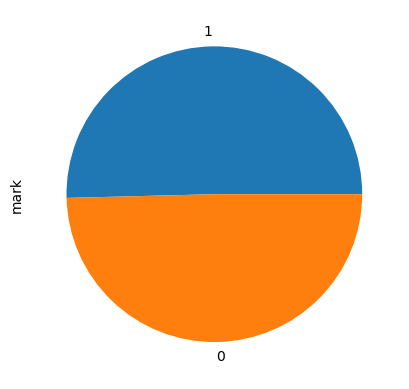

In [100]:
y_train.value_counts().plot(kind='pie')

<Axes: ylabel='mark'>

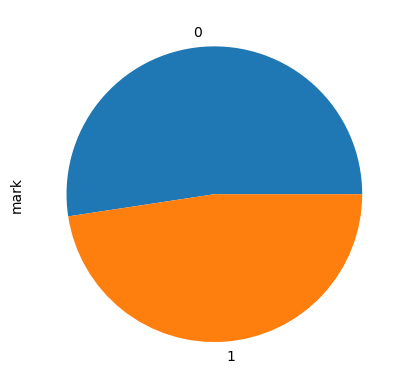

In [101]:
y_test.value_counts().plot(kind='pie')

### Обучение

In [102]:
results_2 = [['type', 'name', 'F1', 'roc_auc', 'time.fit', 'time.pred']]

#### Регрессия

In [141]:
log2 = LogisticRegression(random_state=RANDOM_STATE)

In [142]:
log2.fit(X_train_bert, y_train)

C:\Users\Dmitri\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=101)

In [143]:
log_pred2 = log2.predict(X_test_bert)

In [144]:
print(classification_report(y_test, log_pred2))

              precision    recall  f1-score   support

           0       0.54      0.50      0.52       131
           1       0.49      0.53      0.51       119

    accuracy                           0.51       250
   macro avg       0.51      0.51      0.51       250
weighted avg       0.51      0.51      0.51       250



In [147]:
results_2.append(['bert', 
                  'log', 
                  round(f1_score(y_test, log_pred2), 4), 
                  round(roc_auc_score(y_test, log_pred2), 4), 
                  measure_time(log2.fit, X_train_bert, y_train),
                  measure_time(log2.predict, X_test_bert)])

C:\Users\Dmitri\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Лес

In [148]:
rf2 = RandomForestClassifier(random_state=RANDOM_STATE)

In [149]:
rf2.fit(X_train_bert, y_train)

RandomForestClassifier(random_state=101)

In [150]:
rf_pred2 = rf2.predict(X_test_bert)

In [151]:
results_2.append(['bert', 
                  'forest', 
                  round(f1_score(y_test, rf_pred2), 4), 
                  round(roc_auc_score(y_test, rf_pred2), 4), 
                  measure_time(rf2.fit, X_train_bert, y_train),
                  measure_time(rf2.predict, X_test_bert)])

#### CatBoost

In [152]:
cat2 = CatBoostClassifier(random_state=RANDOM_STATE)

In [153]:
cat2.fit(X_train_bert, y_train)

Learning rate set to 0.010302
0:	learn: 0.6925685	total: 194ms	remaining: 3m 13s
1:	learn: 0.6918015	total: 222ms	remaining: 1m 50s
2:	learn: 0.6908022	total: 250ms	remaining: 1m 23s
3:	learn: 0.6900321	total: 277ms	remaining: 1m 8s
4:	learn: 0.6894726	total: 303ms	remaining: 1m
5:	learn: 0.6890049	total: 330ms	remaining: 54.7s
6:	learn: 0.6883369	total: 358ms	remaining: 50.8s
7:	learn: 0.6878074	total: 386ms	remaining: 47.8s
8:	learn: 0.6871448	total: 414ms	remaining: 45.6s
9:	learn: 0.6864763	total: 443ms	remaining: 43.9s
10:	learn: 0.6858829	total: 473ms	remaining: 42.5s
11:	learn: 0.6853228	total: 501ms	remaining: 41.2s
12:	learn: 0.6847963	total: 529ms	remaining: 40.2s
13:	learn: 0.6841564	total: 557ms	remaining: 39.2s
14:	learn: 0.6831747	total: 585ms	remaining: 38.4s
15:	learn: 0.6824996	total: 613ms	remaining: 37.7s
16:	learn: 0.6817828	total: 640ms	remaining: 37s
17:	learn: 0.6812663	total: 668ms	remaining: 36.4s
18:	learn: 0.6805455	total: 697ms	remaining: 36s
19:	learn: 0.67

165:	learn: 0.6067171	total: 5.1s	remaining: 25.6s
166:	learn: 0.6065801	total: 5.13s	remaining: 25.6s
167:	learn: 0.6060533	total: 5.17s	remaining: 25.6s
168:	learn: 0.6058268	total: 5.2s	remaining: 25.6s
169:	learn: 0.6055381	total: 5.23s	remaining: 25.5s
170:	learn: 0.6051376	total: 5.26s	remaining: 25.5s
171:	learn: 0.6048795	total: 5.29s	remaining: 25.5s
172:	learn: 0.6044122	total: 5.33s	remaining: 25.5s
173:	learn: 0.6038708	total: 5.36s	remaining: 25.4s
174:	learn: 0.6033553	total: 5.38s	remaining: 25.4s
175:	learn: 0.6029198	total: 5.42s	remaining: 25.4s
176:	learn: 0.6023606	total: 5.45s	remaining: 25.3s
177:	learn: 0.6020599	total: 5.48s	remaining: 25.3s
178:	learn: 0.6018478	total: 5.51s	remaining: 25.3s
179:	learn: 0.6013877	total: 5.55s	remaining: 25.3s
180:	learn: 0.6010269	total: 5.58s	remaining: 25.3s
181:	learn: 0.6005837	total: 5.61s	remaining: 25.2s
182:	learn: 0.6002323	total: 5.65s	remaining: 25.2s
183:	learn: 0.5998925	total: 5.68s	remaining: 25.2s
184:	learn: 0.

325:	learn: 0.5508679	total: 10.6s	remaining: 22s
326:	learn: 0.5506500	total: 10.7s	remaining: 22s
327:	learn: 0.5502672	total: 10.7s	remaining: 22s
328:	learn: 0.5500555	total: 10.8s	remaining: 22s
329:	learn: 0.5497307	total: 10.8s	remaining: 21.9s
330:	learn: 0.5495804	total: 10.8s	remaining: 21.9s
331:	learn: 0.5494018	total: 10.9s	remaining: 21.9s
332:	learn: 0.5491441	total: 10.9s	remaining: 21.9s
333:	learn: 0.5488113	total: 10.9s	remaining: 21.8s
334:	learn: 0.5485366	total: 11s	remaining: 21.8s
335:	learn: 0.5481738	total: 11s	remaining: 21.8s
336:	learn: 0.5479177	total: 11.1s	remaining: 21.7s
337:	learn: 0.5478201	total: 11.1s	remaining: 21.7s
338:	learn: 0.5476364	total: 11.1s	remaining: 21.7s
339:	learn: 0.5474417	total: 11.2s	remaining: 21.7s
340:	learn: 0.5472099	total: 11.2s	remaining: 21.6s
341:	learn: 0.5469599	total: 11.2s	remaining: 21.6s
342:	learn: 0.5467399	total: 11.3s	remaining: 21.6s
343:	learn: 0.5466180	total: 11.3s	remaining: 21.5s
344:	learn: 0.5464052	to

486:	learn: 0.5132863	total: 16.7s	remaining: 17.5s
487:	learn: 0.5130425	total: 16.7s	remaining: 17.5s
488:	learn: 0.5128409	total: 16.7s	remaining: 17.5s
489:	learn: 0.5125773	total: 16.8s	remaining: 17.5s
490:	learn: 0.5123695	total: 16.8s	remaining: 17.4s
491:	learn: 0.5122164	total: 16.9s	remaining: 17.4s
492:	learn: 0.5120242	total: 16.9s	remaining: 17.4s
493:	learn: 0.5117270	total: 16.9s	remaining: 17.3s
494:	learn: 0.5115076	total: 17s	remaining: 17.3s
495:	learn: 0.5113778	total: 17s	remaining: 17.3s
496:	learn: 0.5109941	total: 17s	remaining: 17.2s
497:	learn: 0.5107916	total: 17.1s	remaining: 17.2s
498:	learn: 0.5106917	total: 17.1s	remaining: 17.2s
499:	learn: 0.5104839	total: 17.2s	remaining: 17.2s
500:	learn: 0.5102603	total: 17.2s	remaining: 17.1s
501:	learn: 0.5100627	total: 17.2s	remaining: 17.1s
502:	learn: 0.5098923	total: 17.3s	remaining: 17.1s
503:	learn: 0.5096905	total: 17.3s	remaining: 17s
504:	learn: 0.5094711	total: 17.3s	remaining: 17s
505:	learn: 0.5093344	

647:	learn: 0.4823474	total: 23s	remaining: 12.5s
648:	learn: 0.4821807	total: 23s	remaining: 12.4s
649:	learn: 0.4820721	total: 23s	remaining: 12.4s
650:	learn: 0.4819824	total: 23.1s	remaining: 12.4s
651:	learn: 0.4819020	total: 23.1s	remaining: 12.3s
652:	learn: 0.4817233	total: 23.2s	remaining: 12.3s
653:	learn: 0.4816124	total: 23.2s	remaining: 12.3s
654:	learn: 0.4814197	total: 23.2s	remaining: 12.2s
655:	learn: 0.4812959	total: 23.3s	remaining: 12.2s
656:	learn: 0.4811530	total: 23.3s	remaining: 12.2s
657:	learn: 0.4810575	total: 23.4s	remaining: 12.1s
658:	learn: 0.4808453	total: 23.4s	remaining: 12.1s
659:	learn: 0.4806834	total: 23.4s	remaining: 12.1s
660:	learn: 0.4804943	total: 23.5s	remaining: 12s
661:	learn: 0.4803437	total: 23.5s	remaining: 12s
662:	learn: 0.4802212	total: 23.6s	remaining: 12s
663:	learn: 0.4800329	total: 23.6s	remaining: 11.9s
664:	learn: 0.4798881	total: 23.6s	remaining: 11.9s
665:	learn: 0.4796960	total: 23.7s	remaining: 11.9s
666:	learn: 0.4795530	to

808:	learn: 0.4554560	total: 29.7s	remaining: 7s
809:	learn: 0.4552631	total: 29.7s	remaining: 6.97s
810:	learn: 0.4550457	total: 29.8s	remaining: 6.93s
811:	learn: 0.4548645	total: 29.8s	remaining: 6.9s
812:	learn: 0.4547385	total: 29.9s	remaining: 6.87s
813:	learn: 0.4546002	total: 29.9s	remaining: 6.83s
814:	learn: 0.4544733	total: 29.9s	remaining: 6.79s
815:	learn: 0.4543242	total: 30s	remaining: 6.76s
816:	learn: 0.4541843	total: 30s	remaining: 6.72s
817:	learn: 0.4539966	total: 30.1s	remaining: 6.69s
818:	learn: 0.4538765	total: 30.1s	remaining: 6.65s
819:	learn: 0.4536681	total: 30.1s	remaining: 6.62s
820:	learn: 0.4535514	total: 30.2s	remaining: 6.58s
821:	learn: 0.4533188	total: 30.2s	remaining: 6.55s
822:	learn: 0.4532139	total: 30.3s	remaining: 6.51s
823:	learn: 0.4530155	total: 30.3s	remaining: 6.47s
824:	learn: 0.4528657	total: 30.4s	remaining: 6.44s
825:	learn: 0.4526757	total: 30.4s	remaining: 6.4s
826:	learn: 0.4525264	total: 30.4s	remaining: 6.37s
827:	learn: 0.4523820

971:	learn: 0.4292499	total: 36.5s	remaining: 1.05s
972:	learn: 0.4290383	total: 36.6s	remaining: 1.01s
973:	learn: 0.4288557	total: 36.6s	remaining: 978ms
974:	learn: 0.4286770	total: 36.7s	remaining: 940ms
975:	learn: 0.4284501	total: 36.7s	remaining: 903ms
976:	learn: 0.4282944	total: 36.8s	remaining: 865ms
977:	learn: 0.4281010	total: 36.8s	remaining: 828ms
978:	learn: 0.4279947	total: 36.8s	remaining: 790ms
979:	learn: 0.4278096	total: 36.9s	remaining: 753ms
980:	learn: 0.4276123	total: 36.9s	remaining: 715ms
981:	learn: 0.4274951	total: 37s	remaining: 678ms
982:	learn: 0.4274049	total: 37s	remaining: 640ms
983:	learn: 0.4272839	total: 37s	remaining: 602ms
984:	learn: 0.4271261	total: 37.1s	remaining: 565ms
985:	learn: 0.4269879	total: 37.1s	remaining: 527ms
986:	learn: 0.4268513	total: 37.2s	remaining: 490ms
987:	learn: 0.4267175	total: 37.2s	remaining: 452ms
988:	learn: 0.4265702	total: 37.3s	remaining: 414ms
989:	learn: 0.4263991	total: 37.3s	remaining: 377ms
990:	learn: 0.4262

In [154]:
cat_pred2 = cat2.predict(X_test_bert)

In [155]:
results_2.append(['bert', 
                  'cat', 
                  round(f1_score(y_test, cat_pred2), 4), 
                  round(roc_auc_score(y_test, cat_pred2), 4), 
                  measure_time(cat2.fit, X_train_bert, y_train),
                  measure_time(cat2.predict, X_test_bert)])

Learning rate set to 0.010302
0:	learn: 0.6925685	total: 42.3ms	remaining: 42.3s
1:	learn: 0.6918015	total: 78.9ms	remaining: 39.4s
2:	learn: 0.6908022	total: 118ms	remaining: 39.2s
3:	learn: 0.6900321	total: 159ms	remaining: 39.5s
4:	learn: 0.6894726	total: 200ms	remaining: 39.8s
5:	learn: 0.6890049	total: 243ms	remaining: 40.3s
6:	learn: 0.6883369	total: 285ms	remaining: 40.4s
7:	learn: 0.6878074	total: 325ms	remaining: 40.3s
8:	learn: 0.6871448	total: 367ms	remaining: 40.4s
9:	learn: 0.6864763	total: 410ms	remaining: 40.5s
10:	learn: 0.6858829	total: 450ms	remaining: 40.5s
11:	learn: 0.6853228	total: 494ms	remaining: 40.6s
12:	learn: 0.6847963	total: 535ms	remaining: 40.6s
13:	learn: 0.6841564	total: 577ms	remaining: 40.6s
14:	learn: 0.6831747	total: 619ms	remaining: 40.6s
15:	learn: 0.6824996	total: 663ms	remaining: 40.8s
16:	learn: 0.6817828	total: 707ms	remaining: 40.9s
17:	learn: 0.6812663	total: 751ms	remaining: 41s
18:	learn: 0.6805455	total: 798ms	remaining: 41.2s
19:	learn: 

162:	learn: 0.6082659	total: 7.18s	remaining: 36.9s
163:	learn: 0.6077056	total: 7.23s	remaining: 36.9s
164:	learn: 0.6072157	total: 7.28s	remaining: 36.8s
165:	learn: 0.6067171	total: 7.33s	remaining: 36.8s
166:	learn: 0.6065801	total: 7.37s	remaining: 36.8s
167:	learn: 0.6060533	total: 7.42s	remaining: 36.7s
168:	learn: 0.6058268	total: 7.46s	remaining: 36.7s
169:	learn: 0.6055381	total: 7.51s	remaining: 36.7s
170:	learn: 0.6051376	total: 7.55s	remaining: 36.6s
171:	learn: 0.6048795	total: 7.59s	remaining: 36.6s
172:	learn: 0.6044122	total: 7.64s	remaining: 36.5s
173:	learn: 0.6038708	total: 7.68s	remaining: 36.5s
174:	learn: 0.6033553	total: 7.73s	remaining: 36.4s
175:	learn: 0.6029198	total: 7.77s	remaining: 36.4s
176:	learn: 0.6023606	total: 7.82s	remaining: 36.4s
177:	learn: 0.6020599	total: 7.87s	remaining: 36.3s
178:	learn: 0.6018478	total: 7.91s	remaining: 36.3s
179:	learn: 0.6013877	total: 7.95s	remaining: 36.2s
180:	learn: 0.6010269	total: 8s	remaining: 36.2s
181:	learn: 0.6

321:	learn: 0.5519382	total: 14.3s	remaining: 30s
322:	learn: 0.5517697	total: 14.3s	remaining: 30s
323:	learn: 0.5515715	total: 14.3s	remaining: 29.9s
324:	learn: 0.5511822	total: 14.4s	remaining: 29.9s
325:	learn: 0.5508679	total: 14.4s	remaining: 29.8s
326:	learn: 0.5506500	total: 14.5s	remaining: 29.8s
327:	learn: 0.5502672	total: 14.5s	remaining: 29.7s
328:	learn: 0.5500555	total: 14.6s	remaining: 29.7s
329:	learn: 0.5497307	total: 14.6s	remaining: 29.6s
330:	learn: 0.5495804	total: 14.7s	remaining: 29.6s
331:	learn: 0.5494018	total: 14.7s	remaining: 29.6s
332:	learn: 0.5491441	total: 14.7s	remaining: 29.5s
333:	learn: 0.5488113	total: 14.8s	remaining: 29.5s
334:	learn: 0.5485366	total: 14.8s	remaining: 29.4s
335:	learn: 0.5481738	total: 14.9s	remaining: 29.4s
336:	learn: 0.5479177	total: 14.9s	remaining: 29.3s
337:	learn: 0.5478201	total: 14.9s	remaining: 29.3s
338:	learn: 0.5476364	total: 15s	remaining: 29.2s
339:	learn: 0.5474417	total: 15s	remaining: 29.2s
340:	learn: 0.547209

481:	learn: 0.5143478	total: 21.3s	remaining: 22.9s
482:	learn: 0.5141141	total: 21.4s	remaining: 22.9s
483:	learn: 0.5139825	total: 21.4s	remaining: 22.8s
484:	learn: 0.5137855	total: 21.5s	remaining: 22.8s
485:	learn: 0.5135217	total: 21.5s	remaining: 22.7s
486:	learn: 0.5132863	total: 21.5s	remaining: 22.7s
487:	learn: 0.5130425	total: 21.6s	remaining: 22.7s
488:	learn: 0.5128409	total: 21.6s	remaining: 22.6s
489:	learn: 0.5125773	total: 21.7s	remaining: 22.6s
490:	learn: 0.5123695	total: 21.7s	remaining: 22.5s
491:	learn: 0.5122164	total: 21.8s	remaining: 22.5s
492:	learn: 0.5120242	total: 21.8s	remaining: 22.4s
493:	learn: 0.5117270	total: 21.9s	remaining: 22.4s
494:	learn: 0.5115076	total: 21.9s	remaining: 22.3s
495:	learn: 0.5113778	total: 21.9s	remaining: 22.3s
496:	learn: 0.5109941	total: 22s	remaining: 22.3s
497:	learn: 0.5107916	total: 22s	remaining: 22.2s
498:	learn: 0.5106917	total: 22.1s	remaining: 22.2s
499:	learn: 0.5104839	total: 22.1s	remaining: 22.1s
500:	learn: 0.51

641:	learn: 0.4832626	total: 28.4s	remaining: 15.9s
642:	learn: 0.4830715	total: 28.5s	remaining: 15.8s
643:	learn: 0.4829313	total: 28.5s	remaining: 15.8s
644:	learn: 0.4827701	total: 28.6s	remaining: 15.7s
645:	learn: 0.4826180	total: 28.6s	remaining: 15.7s
646:	learn: 0.4824841	total: 28.7s	remaining: 15.6s
647:	learn: 0.4823474	total: 28.7s	remaining: 15.6s
648:	learn: 0.4821807	total: 28.8s	remaining: 15.6s
649:	learn: 0.4820721	total: 28.8s	remaining: 15.5s
650:	learn: 0.4819824	total: 28.8s	remaining: 15.5s
651:	learn: 0.4819020	total: 28.9s	remaining: 15.4s
652:	learn: 0.4817233	total: 28.9s	remaining: 15.4s
653:	learn: 0.4816124	total: 29s	remaining: 15.3s
654:	learn: 0.4814197	total: 29s	remaining: 15.3s
655:	learn: 0.4812959	total: 29.1s	remaining: 15.2s
656:	learn: 0.4811530	total: 29.1s	remaining: 15.2s
657:	learn: 0.4810575	total: 29.2s	remaining: 15.2s
658:	learn: 0.4808453	total: 29.2s	remaining: 15.1s
659:	learn: 0.4806834	total: 29.3s	remaining: 15.1s
660:	learn: 0.48

801:	learn: 0.4565350	total: 35.7s	remaining: 8.82s
802:	learn: 0.4563774	total: 35.8s	remaining: 8.78s
803:	learn: 0.4562326	total: 35.8s	remaining: 8.74s
804:	learn: 0.4560581	total: 35.9s	remaining: 8.69s
805:	learn: 0.4558823	total: 35.9s	remaining: 8.65s
806:	learn: 0.4557079	total: 36s	remaining: 8.6s
807:	learn: 0.4555404	total: 36s	remaining: 8.56s
808:	learn: 0.4554560	total: 36.1s	remaining: 8.51s
809:	learn: 0.4552631	total: 36.1s	remaining: 8.47s
810:	learn: 0.4550457	total: 36.1s	remaining: 8.42s
811:	learn: 0.4548645	total: 36.2s	remaining: 8.38s
812:	learn: 0.4547385	total: 36.2s	remaining: 8.33s
813:	learn: 0.4546002	total: 36.3s	remaining: 8.29s
814:	learn: 0.4544733	total: 36.3s	remaining: 8.25s
815:	learn: 0.4543242	total: 36.4s	remaining: 8.2s
816:	learn: 0.4541843	total: 36.4s	remaining: 8.16s
817:	learn: 0.4539966	total: 36.5s	remaining: 8.11s
818:	learn: 0.4538765	total: 36.5s	remaining: 8.07s
819:	learn: 0.4536681	total: 36.6s	remaining: 8.02s
820:	learn: 0.4535

961:	learn: 0.4307563	total: 43s	remaining: 1.7s
962:	learn: 0.4305930	total: 43s	remaining: 1.65s
963:	learn: 0.4304858	total: 43s	remaining: 1.61s
964:	learn: 0.4303056	total: 43.1s	remaining: 1.56s
965:	learn: 0.4300983	total: 43.1s	remaining: 1.52s
966:	learn: 0.4299104	total: 43.2s	remaining: 1.47s
967:	learn: 0.4297640	total: 43.2s	remaining: 1.43s
968:	learn: 0.4296481	total: 43.3s	remaining: 1.38s
969:	learn: 0.4295362	total: 43.3s	remaining: 1.34s
970:	learn: 0.4293678	total: 43.4s	remaining: 1.29s
971:	learn: 0.4292499	total: 43.4s	remaining: 1.25s
972:	learn: 0.4290383	total: 43.5s	remaining: 1.21s
973:	learn: 0.4288557	total: 43.5s	remaining: 1.16s
974:	learn: 0.4286770	total: 43.5s	remaining: 1.12s
975:	learn: 0.4284501	total: 43.6s	remaining: 1.07s
976:	learn: 0.4282944	total: 43.6s	remaining: 1.03s
977:	learn: 0.4281010	total: 43.7s	remaining: 983ms
978:	learn: 0.4279947	total: 43.7s	remaining: 938ms
979:	learn: 0.4278096	total: 43.8s	remaining: 893ms
980:	learn: 0.42761

#### GradientBoost

In [156]:
gbc2 = GradientBoostingClassifier(random_state=RANDOM_STATE)

In [157]:
gbc2.fit(X_train_bert, y_train)

GradientBoostingClassifier(random_state=101)

In [158]:
gbc_pred2 = gbc2.predict(X_test_bert)

In [159]:
results_2.append(['bert', 
                  'gbc', 
                  round(f1_score(y_test, gbc_pred2), 4), 
                  round(roc_auc_score(y_test, gbc_pred2), 4), 
                  measure_time(gbc2.fit, X_train_bert, y_train),
                  measure_time(gbc2.predict, X_test_bert)])

#### LGBMBoost

In [160]:
lgbm2 = LGBMClassifier(random_state=RANDOM_STATE)

In [161]:
lgbm2.fit(X_train_bert, y_train)

[LightGBM] [Info] Number of positive: 504, number of negative: 496
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195830
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504000 -> initscore=0.016000
[LightGBM] [Info] Start training from score 0.016000


LGBMClassifier(random_state=101)

In [162]:
lgbm_pred2 = lgbm2.predict(X_test_bert)

In [163]:
results_2.append(['bert', 
                  'lgbm', 
                  round(f1_score(y_test, lgbm_pred2), 4), 
                  round(roc_auc_score(y_test, lgbm_pred2), 4), 
                  measure_time(lgbm2.fit, X_train_bert, y_train),
                  measure_time(lgbm2.predict, X_test_bert)])

[LightGBM] [Info] Number of positive: 504, number of negative: 496
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195830
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504000 -> initscore=0.016000
[LightGBM] [Info] Start training from score 0.016000


### Вывод

In [183]:
results_bert = pd.DataFrame(results_2[1:], columns=results_2[0])

In [184]:
results_bert['time.fit'] = results_bert['time.fit']/60
results_bert.rename(columns={'time.fit': 'time.fit_min'}, inplace=True)

In [185]:
results_bert['time.pred'] = results_bert['time.pred']+1.780 #на токенизацию

In [186]:
results_bert

,type,name,F1,roc_auc,time.fit_min,time.pred
0,bert,log,0.5081,0.5128,0.000967,1.7855
1,bert,forest,0.4310,0.4696,0.068878,1.7921
2,bert,cat,0.4286,0.4547,0.753465,1.8118
3,bert,gbc,0.4739,0.4769,0.521092,1.7850
4,bert,lgbm,0.4257,0.4288,0.015608,1.7896


Таким образом, мы:
- векторизовали бертом данные
- обучили на них модели, посчитали их качество и время работы
- собрали данные в таблицу
- также добавили 1.78 секунды как время работы векторизации

# Решение на основе статистических данных предложения

Модель считывает информацию с текста, вне его лексического наполнения: 

- количество слов различной капитализации 
- количество слов с цифрами внутри и без 
- количество точек, запятых, тире, двоеточий, вопросов 
- средняя длина слова 
- длина строки 

Для считывания информации создана функция get_info

In [216]:
def get_info(text):
    if type(text) == str:
        text = text.split("\n")
    info = []
    for i in text:
        l = 0  # lower
        u = 0  # upper
        m = 0  # mix
        n = 0  # only numbers
        nw = 0  # words with numbers
        nnw = 0  # words without numbers
        lenw = []
        for word in i.replace(".", "").replace(",", "").replace(":", "").split(" "):
            if i.islower():
                l += 1
            elif i.isupper():
                u += 1
            else:
                m += 1

            if word.isdigit():
                n += 1
            elif any(char.isdigit() for char in word):
                nw += 1
            else:
                nnw += 1
            lenw.append(len(word))

        p = i.count(".")
        c = i.count(",")
        cl = i.count(":")
        d = i.count("-")
        q = i.count("?")
        ln = len(i)
        lnw = sum(lenw) / len(lenw)
        sp = i.count(' ')

        info.append(
            [
                l,  # lower case
                u,  # upper case
                m,  # mix case
                nw,  # words with numbers
                nnw,  # words without numbers
                n,  # only numbers
                p,  # full stop
                c,  # comma
                cl,  # colon
                d,  # dash
                q,  # questions
                ln,  # lenth
                lnw, # mean word lenth
                sp
            ]
        )  
    return info

### Подготовка данных

In [212]:
data = pd.read_csv(r"C:\Users\Dmitri\Downloads\NLP\the_data.csv")[['string', 'mark']]

In [213]:
X = data['string']
y = data['mark'].astype(int)

In [214]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=RANDOM_STATE)

In [217]:
X_train_stat = []
for i in tqdm(list(X_train)):
    X_train_stat.append(get_info(i)[0])

100%|███████████████████████████████████████████████████████████████████████| 106089/106089 [00:02<00:00, 35374.39it/s]


In [218]:
X_test_stat = []
for i in tqdm(list(X_test)):
    X_test_stat.append(get_info(i)[0])

100%|█████████████████████████████████████████████████████████████████████████| 35363/35363 [00:00<00:00, 37892.54it/s]


<Axes: ylabel='mark'>

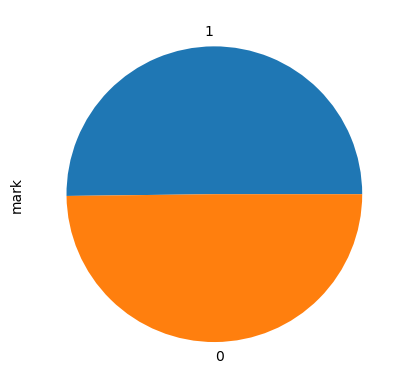

In [219]:
y_train.value_counts().plot(kind='pie')

<Axes: ylabel='mark'>

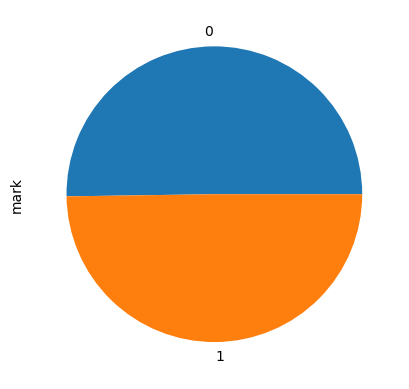

In [220]:
y_test.value_counts().plot(kind='pie')

### Обучение

In [51]:
results_3 = [['type', 'name', 'F1', 'roc_auc', 'time.fit', 'time.pred']]

#### Регрессия

In [232]:
log3 = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000000)

In [233]:
log3.fit(X_train_stat, y_train)

LogisticRegression(max_iter=1000000, random_state=101)

In [44]:
log_pred3 = log3.predict(X_test_stat)

In [45]:
print(classification_report(y_test, log_pred3))

              precision    recall  f1-score   support

           0       0.88      0.51      0.65     17764
           1       0.65      0.93      0.77     17599

    accuracy                           0.72     35363
   macro avg       0.77      0.72      0.71     35363
weighted avg       0.77      0.72      0.71     35363



In [52]:
results_3.append(['stat', 
                  'log', 
                  round(f1_score(y_test, log_pred3), 4), 
                  round(roc_auc_score(y_test, log_pred3), 4), 
                  measure_time(log3.fit, X_train_stat, y_train),
                  measure_time(log3.predict, X_test_stat)])

#### Лес

In [47]:
rf3 = RandomForestClassifier(random_state=RANDOM_STATE)

In [48]:
rf3.fit(X_train_stat, y_train)

RandomForestClassifier(random_state=101)

In [49]:
rf_pred3 = rf3.predict(X_test_stat)

In [53]:
results_3.append(['stat', 
                  'forest', 
                  round(f1_score(y_test, rf_pred3), 4), 
                  round(roc_auc_score(y_test, rf_pred3), 4), 
                  measure_time(rf3.fit, X_train_stat, y_train),
                  measure_time(rf3.predict, X_test_stat)])

#### CatBoost

In [54]:
cat3 = CatBoostClassifier(random_state=RANDOM_STATE)

In [55]:
cat3.fit(X_train_stat, y_train)

Learning rate set to 0.075491
0:	learn: 0.6380777	total: 223ms	remaining: 3m 43s
1:	learn: 0.5985246	total: 250ms	remaining: 2m 4s
2:	learn: 0.5680078	total: 275ms	remaining: 1m 31s
3:	learn: 0.5449022	total: 299ms	remaining: 1m 14s
4:	learn: 0.5263304	total: 321ms	remaining: 1m 3s
5:	learn: 0.5111484	total: 343ms	remaining: 56.9s
6:	learn: 0.5005991	total: 365ms	remaining: 51.8s
7:	learn: 0.4896243	total: 386ms	remaining: 47.9s
8:	learn: 0.4815803	total: 408ms	remaining: 44.9s
9:	learn: 0.4751545	total: 429ms	remaining: 42.5s
10:	learn: 0.4688000	total: 450ms	remaining: 40.5s
11:	learn: 0.4633605	total: 475ms	remaining: 39.1s
12:	learn: 0.4585621	total: 496ms	remaining: 37.6s
13:	learn: 0.4548576	total: 516ms	remaining: 36.3s
14:	learn: 0.4512350	total: 535ms	remaining: 35.1s
15:	learn: 0.4486979	total: 555ms	remaining: 34.1s
16:	learn: 0.4457612	total: 575ms	remaining: 33.3s
17:	learn: 0.4430617	total: 596ms	remaining: 32.5s
18:	learn: 0.4408469	total: 616ms	remaining: 31.8s
19:	lear

161:	learn: 0.4102218	total: 5.73s	remaining: 29.7s
162:	learn: 0.4101384	total: 5.8s	remaining: 29.8s
163:	learn: 0.4100884	total: 5.84s	remaining: 29.8s
164:	learn: 0.4099994	total: 5.87s	remaining: 29.7s
165:	learn: 0.4099505	total: 5.89s	remaining: 29.6s
166:	learn: 0.4099002	total: 5.92s	remaining: 29.5s
167:	learn: 0.4098241	total: 5.97s	remaining: 29.6s
168:	learn: 0.4097666	total: 6.04s	remaining: 29.7s
169:	learn: 0.4097125	total: 6.07s	remaining: 29.7s
170:	learn: 0.4096441	total: 6.1s	remaining: 29.6s
171:	learn: 0.4095962	total: 6.13s	remaining: 29.5s
172:	learn: 0.4095413	total: 6.2s	remaining: 29.6s
173:	learn: 0.4094587	total: 6.26s	remaining: 29.7s
174:	learn: 0.4093927	total: 6.33s	remaining: 29.8s
175:	learn: 0.4093077	total: 6.36s	remaining: 29.8s
176:	learn: 0.4092658	total: 6.39s	remaining: 29.7s
177:	learn: 0.4091525	total: 6.44s	remaining: 29.7s
178:	learn: 0.4090653	total: 6.51s	remaining: 29.8s
179:	learn: 0.4090160	total: 6.54s	remaining: 29.8s
180:	learn: 0.4

324:	learn: 0.4035852	total: 13.1s	remaining: 27.2s
325:	learn: 0.4035682	total: 13.2s	remaining: 27.2s
326:	learn: 0.4035494	total: 13.2s	remaining: 27.2s
327:	learn: 0.4035369	total: 13.2s	remaining: 27.1s
328:	learn: 0.4034990	total: 13.3s	remaining: 27.1s
329:	learn: 0.4034690	total: 13.3s	remaining: 27s
330:	learn: 0.4034129	total: 13.4s	remaining: 27.1s
331:	learn: 0.4033894	total: 13.4s	remaining: 27s
332:	learn: 0.4033625	total: 13.5s	remaining: 26.9s
333:	learn: 0.4033469	total: 13.5s	remaining: 26.9s
334:	learn: 0.4033191	total: 13.5s	remaining: 26.8s
335:	learn: 0.4032835	total: 13.6s	remaining: 26.9s
336:	learn: 0.4032395	total: 13.6s	remaining: 26.8s
337:	learn: 0.4032269	total: 13.7s	remaining: 26.8s
338:	learn: 0.4032054	total: 13.7s	remaining: 26.7s
339:	learn: 0.4031924	total: 13.7s	remaining: 26.6s
340:	learn: 0.4031714	total: 13.7s	remaining: 26.6s
341:	learn: 0.4031453	total: 13.8s	remaining: 26.5s
342:	learn: 0.4031204	total: 13.8s	remaining: 26.5s
343:	learn: 0.40

484:	learn: 0.4001297	total: 19.9s	remaining: 21.1s
485:	learn: 0.4001193	total: 19.9s	remaining: 21.1s
486:	learn: 0.4000923	total: 20s	remaining: 21s
487:	learn: 0.4000594	total: 20s	remaining: 21s
488:	learn: 0.4000380	total: 20s	remaining: 20.9s
489:	learn: 0.3999983	total: 20.1s	remaining: 20.9s
490:	learn: 0.3999838	total: 20.1s	remaining: 20.9s
491:	learn: 0.3999553	total: 20.2s	remaining: 20.8s
492:	learn: 0.3999377	total: 20.2s	remaining: 20.8s
493:	learn: 0.3999160	total: 20.3s	remaining: 20.8s
494:	learn: 0.3998956	total: 20.3s	remaining: 20.7s
495:	learn: 0.3998771	total: 20.4s	remaining: 20.7s
496:	learn: 0.3998647	total: 20.4s	remaining: 20.6s
497:	learn: 0.3998382	total: 20.5s	remaining: 20.6s
498:	learn: 0.3998249	total: 20.5s	remaining: 20.6s
499:	learn: 0.3998106	total: 20.5s	remaining: 20.5s
500:	learn: 0.3997959	total: 20.6s	remaining: 20.5s
501:	learn: 0.3997717	total: 20.6s	remaining: 20.4s
502:	learn: 0.3997466	total: 20.7s	remaining: 20.4s
503:	learn: 0.3997227	

646:	learn: 0.3973493	total: 27.3s	remaining: 14.9s
647:	learn: 0.3973346	total: 27.3s	remaining: 14.8s
648:	learn: 0.3973138	total: 27.4s	remaining: 14.8s
649:	learn: 0.3973001	total: 27.4s	remaining: 14.8s
650:	learn: 0.3972858	total: 27.5s	remaining: 14.7s
651:	learn: 0.3972750	total: 27.5s	remaining: 14.7s
652:	learn: 0.3972559	total: 27.5s	remaining: 14.6s
653:	learn: 0.3972440	total: 27.6s	remaining: 14.6s
654:	learn: 0.3972259	total: 27.6s	remaining: 14.6s
655:	learn: 0.3972094	total: 27.7s	remaining: 14.5s
656:	learn: 0.3971975	total: 27.7s	remaining: 14.5s
657:	learn: 0.3971862	total: 27.8s	remaining: 14.4s
658:	learn: 0.3971614	total: 27.8s	remaining: 14.4s
659:	learn: 0.3971487	total: 27.9s	remaining: 14.3s
660:	learn: 0.3971418	total: 27.9s	remaining: 14.3s
661:	learn: 0.3971304	total: 27.9s	remaining: 14.2s
662:	learn: 0.3971204	total: 28s	remaining: 14.2s
663:	learn: 0.3970992	total: 28s	remaining: 14.2s
664:	learn: 0.3970838	total: 28.1s	remaining: 14.1s
665:	learn: 0.39

807:	learn: 0.3950345	total: 34.6s	remaining: 8.22s
808:	learn: 0.3950058	total: 34.6s	remaining: 8.17s
809:	learn: 0.3950000	total: 34.6s	remaining: 8.13s
810:	learn: 0.3949991	total: 34.7s	remaining: 8.08s
811:	learn: 0.3949989	total: 34.7s	remaining: 8.04s
812:	learn: 0.3949723	total: 34.8s	remaining: 8s
813:	learn: 0.3949643	total: 34.8s	remaining: 7.96s
814:	learn: 0.3949439	total: 34.8s	remaining: 7.91s
815:	learn: 0.3949258	total: 34.9s	remaining: 7.86s
816:	learn: 0.3949025	total: 34.9s	remaining: 7.82s
817:	learn: 0.3949023	total: 35s	remaining: 7.78s
818:	learn: 0.3948886	total: 35s	remaining: 7.74s
819:	learn: 0.3948783	total: 35s	remaining: 7.69s
820:	learn: 0.3948732	total: 35.1s	remaining: 7.65s
821:	learn: 0.3948585	total: 35.2s	remaining: 7.61s
822:	learn: 0.3948582	total: 35.2s	remaining: 7.57s
823:	learn: 0.3948407	total: 35.2s	remaining: 7.52s
824:	learn: 0.3948234	total: 35.3s	remaining: 7.48s
825:	learn: 0.3948136	total: 35.3s	remaining: 7.44s
826:	learn: 0.3947976

967:	learn: 0.3930512	total: 41.7s	remaining: 1.38s
968:	learn: 0.3930421	total: 41.7s	remaining: 1.33s
969:	learn: 0.3930315	total: 41.8s	remaining: 1.29s
970:	learn: 0.3930238	total: 41.8s	remaining: 1.25s
971:	learn: 0.3930083	total: 41.8s	remaining: 1.21s
972:	learn: 0.3929906	total: 41.9s	remaining: 1.16s
973:	learn: 0.3929789	total: 42s	remaining: 1.12s
974:	learn: 0.3929698	total: 42s	remaining: 1.08s
975:	learn: 0.3929692	total: 42.1s	remaining: 1.03s
976:	learn: 0.3929528	total: 42.1s	remaining: 992ms
977:	learn: 0.3929407	total: 42.2s	remaining: 948ms
978:	learn: 0.3929268	total: 42.2s	remaining: 906ms
979:	learn: 0.3929050	total: 42.3s	remaining: 863ms
980:	learn: 0.3929031	total: 42.3s	remaining: 820ms
981:	learn: 0.3928856	total: 42.4s	remaining: 777ms
982:	learn: 0.3928819	total: 42.5s	remaining: 734ms
983:	learn: 0.3928792	total: 42.5s	remaining: 691ms
984:	learn: 0.3928686	total: 42.5s	remaining: 648ms
985:	learn: 0.3928598	total: 42.6s	remaining: 604ms
986:	learn: 0.39

In [56]:
cat_pred3 = cat3.predict(X_test_stat)

In [57]:
results_3.append(['stat', 
                  'cat', 
                  round(f1_score(y_test, cat_pred3), 4), 
                  round(roc_auc_score(y_test, cat_pred3), 4), 
                  measure_time(cat3.fit, X_train_stat, y_train),
                  measure_time(cat3.predict, X_test_stat)])

Learning rate set to 0.075491
0:	learn: 0.6380777	total: 28.8ms	remaining: 28.7s
1:	learn: 0.5985246	total: 52.9ms	remaining: 26.4s
2:	learn: 0.5680078	total: 97.3ms	remaining: 32.3s
3:	learn: 0.5449022	total: 174ms	remaining: 43.4s
4:	learn: 0.5263304	total: 210ms	remaining: 41.8s
5:	learn: 0.5111484	total: 286ms	remaining: 47.4s
6:	learn: 0.5005991	total: 335ms	remaining: 47.5s
7:	learn: 0.4896243	total: 362ms	remaining: 44.8s
8:	learn: 0.4815803	total: 449ms	remaining: 49.4s
9:	learn: 0.4751545	total: 495ms	remaining: 49s
10:	learn: 0.4688000	total: 532ms	remaining: 47.9s
11:	learn: 0.4633605	total: 612ms	remaining: 50.4s
12:	learn: 0.4585621	total: 645ms	remaining: 48.9s
13:	learn: 0.4548576	total: 672ms	remaining: 47.3s
14:	learn: 0.4512350	total: 697ms	remaining: 45.8s
15:	learn: 0.4486979	total: 791ms	remaining: 48.7s
16:	learn: 0.4457612	total: 833ms	remaining: 48.2s
17:	learn: 0.4430617	total: 865ms	remaining: 47.2s
18:	learn: 0.4408469	total: 894ms	remaining: 46.2s
19:	learn:

164:	learn: 0.4099994	total: 7.39s	remaining: 37.4s
165:	learn: 0.4099505	total: 7.44s	remaining: 37.4s
166:	learn: 0.4099002	total: 7.47s	remaining: 37.3s
167:	learn: 0.4098241	total: 7.5s	remaining: 37.2s
168:	learn: 0.4097666	total: 7.53s	remaining: 37s
169:	learn: 0.4097125	total: 7.56s	remaining: 36.9s
170:	learn: 0.4096441	total: 7.64s	remaining: 37.1s
171:	learn: 0.4095962	total: 7.68s	remaining: 37s
172:	learn: 0.4095413	total: 7.71s	remaining: 36.8s
173:	learn: 0.4094587	total: 7.73s	remaining: 36.7s
174:	learn: 0.4093927	total: 7.75s	remaining: 36.6s
175:	learn: 0.4093077	total: 7.83s	remaining: 36.6s
176:	learn: 0.4092658	total: 7.88s	remaining: 36.6s
177:	learn: 0.4091525	total: 7.91s	remaining: 36.5s
178:	learn: 0.4090653	total: 7.93s	remaining: 36.4s
179:	learn: 0.4090160	total: 7.96s	remaining: 36.2s
180:	learn: 0.4089557	total: 8.03s	remaining: 36.4s
181:	learn: 0.4089368	total: 8.09s	remaining: 36.3s
182:	learn: 0.4088692	total: 8.13s	remaining: 36.3s
183:	learn: 0.408

326:	learn: 0.4035494	total: 14.3s	remaining: 29.5s
327:	learn: 0.4035369	total: 14.4s	remaining: 29.5s
328:	learn: 0.4034990	total: 14.4s	remaining: 29.4s
329:	learn: 0.4034690	total: 14.5s	remaining: 29.4s
330:	learn: 0.4034129	total: 14.5s	remaining: 29.3s
331:	learn: 0.4033894	total: 14.5s	remaining: 29.2s
332:	learn: 0.4033625	total: 14.6s	remaining: 29.3s
333:	learn: 0.4033469	total: 14.6s	remaining: 29.2s
334:	learn: 0.4033191	total: 14.7s	remaining: 29.1s
335:	learn: 0.4032835	total: 14.7s	remaining: 29s
336:	learn: 0.4032395	total: 14.7s	remaining: 29s
337:	learn: 0.4032269	total: 14.8s	remaining: 29s
338:	learn: 0.4032054	total: 14.8s	remaining: 28.9s
339:	learn: 0.4031924	total: 14.9s	remaining: 28.9s
340:	learn: 0.4031714	total: 14.9s	remaining: 28.8s
341:	learn: 0.4031453	total: 15s	remaining: 28.8s
342:	learn: 0.4031204	total: 15s	remaining: 28.8s
343:	learn: 0.4030642	total: 15s	remaining: 28.7s
344:	learn: 0.4030378	total: 15.1s	remaining: 28.6s
345:	learn: 0.4030144	to

489:	learn: 0.3999983	total: 21.5s	remaining: 22.4s
490:	learn: 0.3999838	total: 21.6s	remaining: 22.4s
491:	learn: 0.3999553	total: 21.6s	remaining: 22.3s
492:	learn: 0.3999377	total: 21.6s	remaining: 22.3s
493:	learn: 0.3999160	total: 21.7s	remaining: 22.2s
494:	learn: 0.3998956	total: 21.8s	remaining: 22.2s
495:	learn: 0.3998771	total: 21.8s	remaining: 22.1s
496:	learn: 0.3998647	total: 21.8s	remaining: 22.1s
497:	learn: 0.3998382	total: 21.9s	remaining: 22.1s
498:	learn: 0.3998249	total: 21.9s	remaining: 22s
499:	learn: 0.3998106	total: 22s	remaining: 22s
500:	learn: 0.3997959	total: 22s	remaining: 21.9s
501:	learn: 0.3997717	total: 22s	remaining: 21.9s
502:	learn: 0.3997466	total: 22.1s	remaining: 21.8s
503:	learn: 0.3997227	total: 22.1s	remaining: 21.8s
504:	learn: 0.3997126	total: 22.2s	remaining: 21.7s
505:	learn: 0.3996838	total: 22.2s	remaining: 21.7s
506:	learn: 0.3996764	total: 22.3s	remaining: 21.6s
507:	learn: 0.3996520	total: 22.3s	remaining: 21.6s
508:	learn: 0.3996367	

649:	learn: 0.3973001	total: 28.3s	remaining: 15.3s
650:	learn: 0.3972858	total: 28.4s	remaining: 15.2s
651:	learn: 0.3972750	total: 28.5s	remaining: 15.2s
652:	learn: 0.3972559	total: 28.5s	remaining: 15.2s
653:	learn: 0.3972440	total: 28.5s	remaining: 15.1s
654:	learn: 0.3972259	total: 28.6s	remaining: 15s
655:	learn: 0.3972094	total: 28.6s	remaining: 15s
656:	learn: 0.3971975	total: 28.6s	remaining: 14.9s
657:	learn: 0.3971862	total: 28.7s	remaining: 14.9s
658:	learn: 0.3971614	total: 28.7s	remaining: 14.9s
659:	learn: 0.3971487	total: 28.8s	remaining: 14.8s
660:	learn: 0.3971418	total: 28.8s	remaining: 14.8s
661:	learn: 0.3971304	total: 28.8s	remaining: 14.7s
662:	learn: 0.3971204	total: 28.9s	remaining: 14.7s
663:	learn: 0.3970992	total: 29s	remaining: 14.7s
664:	learn: 0.3970838	total: 29s	remaining: 14.6s
665:	learn: 0.3970674	total: 29s	remaining: 14.6s
666:	learn: 0.3970644	total: 29.1s	remaining: 14.5s
667:	learn: 0.3970371	total: 29.1s	remaining: 14.5s
668:	learn: 0.3970195	

810:	learn: 0.3949991	total: 35.3s	remaining: 8.23s
811:	learn: 0.3949989	total: 35.4s	remaining: 8.19s
812:	learn: 0.3949723	total: 35.4s	remaining: 8.14s
813:	learn: 0.3949643	total: 35.5s	remaining: 8.11s
814:	learn: 0.3949439	total: 35.5s	remaining: 8.06s
815:	learn: 0.3949258	total: 35.5s	remaining: 8.01s
816:	learn: 0.3949025	total: 35.6s	remaining: 7.96s
817:	learn: 0.3949023	total: 35.6s	remaining: 7.92s
818:	learn: 0.3948886	total: 35.7s	remaining: 7.89s
819:	learn: 0.3948783	total: 35.7s	remaining: 7.84s
820:	learn: 0.3948732	total: 35.7s	remaining: 7.79s
821:	learn: 0.3948585	total: 35.8s	remaining: 7.75s
822:	learn: 0.3948582	total: 35.8s	remaining: 7.7s
823:	learn: 0.3948407	total: 35.9s	remaining: 7.66s
824:	learn: 0.3948234	total: 35.9s	remaining: 7.62s
825:	learn: 0.3948136	total: 36s	remaining: 7.58s
826:	learn: 0.3947976	total: 36s	remaining: 7.53s
827:	learn: 0.3947790	total: 36s	remaining: 7.49s
828:	learn: 0.3947683	total: 36.1s	remaining: 7.45s
829:	learn: 0.39475

974:	learn: 0.3929698	total: 42.2s	remaining: 1.08s
975:	learn: 0.3929692	total: 42.3s	remaining: 1.04s
976:	learn: 0.3929528	total: 42.3s	remaining: 996ms
977:	learn: 0.3929407	total: 42.4s	remaining: 953ms
978:	learn: 0.3929268	total: 42.4s	remaining: 910ms
979:	learn: 0.3929050	total: 42.5s	remaining: 867ms
980:	learn: 0.3929031	total: 42.5s	remaining: 823ms
981:	learn: 0.3928856	total: 42.6s	remaining: 781ms
982:	learn: 0.3928819	total: 42.6s	remaining: 737ms
983:	learn: 0.3928792	total: 42.7s	remaining: 694ms
984:	learn: 0.3928686	total: 42.8s	remaining: 651ms
985:	learn: 0.3928598	total: 42.8s	remaining: 608ms
986:	learn: 0.3928573	total: 42.8s	remaining: 564ms
987:	learn: 0.3928411	total: 42.9s	remaining: 521ms
988:	learn: 0.3928326	total: 42.9s	remaining: 478ms
989:	learn: 0.3928276	total: 43s	remaining: 434ms
990:	learn: 0.3928158	total: 43s	remaining: 391ms
991:	learn: 0.3928051	total: 43.1s	remaining: 347ms
992:	learn: 0.3927856	total: 43.1s	remaining: 304ms
993:	learn: 0.39

#### GradientBoost

In [58]:
gbc3 = GradientBoostingClassifier(random_state=RANDOM_STATE)

In [59]:
gbc3.fit(X_train_stat, y_train)

GradientBoostingClassifier(random_state=101)

In [60]:
gbc_pred3 = gbc3.predict(X_test_stat)

In [61]:
results_3.append(['stat', 
                  'gbc', 
                  round(f1_score(y_test, gbc_pred3), 4), 
                  round(roc_auc_score(y_test, gbc_pred3), 4), 
                  measure_time(gbc3.fit, X_train_stat, y_train),
                  measure_time(gbc3.predict, X_test_stat)])

#### LGBMBoost

In [234]:
lgbm3 = LGBMClassifier(random_state=RANDOM_STATE)

In [235]:
lgbm3.fit(X_train_stat, y_train)

[LightGBM] [Info] Number of positive: 53245, number of negative: 52844
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1848
[LightGBM] [Info] Number of data points in the train set: 106089, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501890 -> initscore=0.007560
[LightGBM] [Info] Start training from score 0.007560


LGBMClassifier(random_state=101)

In [68]:
lgbm_pred3 = lgbm3.predict(X_test_stat)

In [69]:
results_3.append(['stat', 
                  'lgbm', 
                  round(f1_score(y_test, lgbm_pred3), 4), 
                  round(roc_auc_score(y_test, lgbm_pred3), 4), 
                  measure_time(lgbm3.fit, X_train_stat, y_train),
                  measure_time(lgbm3.predict, X_test_stat)])

[LightGBM] [Info] Number of positive: 53245, number of negative: 52844
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1848
[LightGBM] [Info] Number of data points in the train set: 106089, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501890 -> initscore=0.007560
[LightGBM] [Info] Start training from score 0.007560


### Вывод

In [70]:
results_stat = pd.DataFrame(results_3[1:], columns=results_3[0])

In [71]:
results_stat['time.fit'] = results_stat['time.fit']/60
results_stat.rename(columns={'time.fit': 'time.fit min'}, inplace=True)

In [72]:
results_stat

,type,name,F1,roc_auc,time.fit min,time.pred
0,stat,log,0.7674,0.7203,0.079237,0.0821
1,stat,forest,0.7907,0.7685,0.520695,2.1594
2,stat,cat,0.8294,0.8053,0.743682,0.3387
3,stat,gbc,0.8228,0.7997,0.488718,0.1765
4,stat,lgbm,0.8315,0.8063,0.020922,0.1859


Таким образом, мы:
- разработали алгоритм для поиска фичей в данных
- создали матрицу данных
- обучили и протестировали модели, собрали данные

## Вывод

Мы собрали данные по классификации. Теперь можем провести аналитику и выявить лучшую модель.

In [201]:
results_tf_idf

,type,name,F1,roc_auc,time.fit_min,time.pred
0,tf-idf,log,0.6667,0.6529,0.232670,1.4561
1,tf-idf,forest,0.6348,0.5967,17.150245,1.7995
2,tf-idf,cat,0.6940,0.6801,5.243195,36.0499
3,tf-idf,gbc,0.7515,0.6771,27.979575,0.4732
4,tf-idf,lgbm,0.6576,0.6580,0.066955,0.9365


In [202]:
results_bert

,type,name,F1,roc_auc,time.fit_min,time.pred
0,bert,log,0.5081,0.5128,0.000967,1.7855
1,bert,forest,0.4310,0.4696,0.068878,1.7921
2,bert,cat,0.4286,0.4547,0.753465,1.8118
3,bert,gbc,0.4739,0.4769,0.521092,1.7850
4,bert,lgbm,0.4257,0.4288,0.015608,1.7896


In [203]:
results_stat

,type,name,F1,roc_auc,time.fit_min,time.pred
0,stat,log,0.7674,0.7203,0.079237,0.0821
1,stat,forest,0.7907,0.7685,0.520695,2.1594
2,stat,cat,0.8294,0.8053,0.743682,0.3387
3,stat,gbc,0.8228,0.7997,0.488718,0.1765
4,stat,lgbm,0.8315,0.8063,0.020922,0.1859


In [204]:
result = pd.merge(pd.merge(results_tf_idf, results_stat, how='outer'), results_bert, how='outer')
result

,type,name,F1,roc_auc,time.fit_min,time.pred
0,tf-idf,log,0.6667,0.6529,0.232670,1.4561
1,tf-idf,forest,0.6348,0.5967,17.150245,1.7995
2,tf-idf,cat,0.6940,0.6801,5.243195,36.0499
3,tf-idf,gbc,0.7515,0.6771,27.979575,0.4732
4,tf-idf,lgbm,0.6576,0.6580,0.066955,0.9365
5,stat,log,0.7674,0.7203,0.079237,0.0821
6,stat,forest,0.7907,0.7685,0.520695,2.1594
7,stat,cat,0.8294,0.8053,0.743682,0.3387
8,stat,gbc,0.8228,0.7997,0.488718,0.1765
9,stat,lgbm,0.8315,0.8063,0.020922,0.1859


### Анализ

In [205]:
def highlight_first_two_rows(s):
    return ['background-color: yellow' if i < 1 else '' for i in range(len(s))]

In [206]:
result.sort_values('F1', ascending=False).head(5).style.apply(highlight_first_two_rows)

,type,name,F1,roc_auc,time.fit_min,time.pred
9,stat,lgbm,0.831500,0.806300,0.020922,0.185900
7,stat,cat,0.829400,0.805300,0.743682,0.338700
8,stat,gbc,0.822800,0.799700,0.488718,0.176500
6,stat,forest,0.790700,0.768500,0.520695,2.159400
5,stat,log,0.767400,0.720300,0.079237,0.082100


In [207]:
result.sort_values('roc_auc', ascending=False).head(5).style.apply(highlight_first_two_rows)

,type,name,F1,roc_auc,time.fit_min,time.pred
9,stat,lgbm,0.831500,0.806300,0.020922,0.185900
7,stat,cat,0.829400,0.805300,0.743682,0.338700
8,stat,gbc,0.822800,0.799700,0.488718,0.176500
6,stat,forest,0.790700,0.768500,0.520695,2.159400
5,stat,log,0.767400,0.720300,0.079237,0.082100


In [208]:
result.sort_values('time.pred').head(5).style.apply(highlight_first_two_rows)

,type,name,F1,roc_auc,time.fit_min,time.pred
5,stat,log,0.767400,0.720300,0.079237,0.082100
8,stat,gbc,0.822800,0.799700,0.488718,0.176500
9,stat,lgbm,0.831500,0.806300,0.020922,0.185900
7,stat,cat,0.829400,0.805300,0.743682,0.338700
3,tf-idf,gbc,0.751500,0.677100,27.979575,0.473200


# Кластеризация

In [221]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [224]:
kmeans = KMeans(n_clusters=2, random_state=RANDOM_STATE)
kmeans.fit(X_train_stat)

C:\Users\Dmitri\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=2, random_state=101)

In [225]:
y_pred_train = kmeans.predict(X_train_stat)
y_pred_test = kmeans.predict(X_test_stat)

In [228]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.50      0.94      0.65     52844
           1       0.47      0.06      0.10     53245

    accuracy                           0.49    106089
   macro avg       0.48      0.50      0.38    106089
weighted avg       0.48      0.49      0.37    106089



In [229]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.50      0.93      0.65     17764
           1       0.46      0.06      0.10     17599

    accuracy                           0.50     35363
   macro avg       0.48      0.50      0.38     35363
weighted avg       0.48      0.50      0.38     35363



In [231]:
round(f1_score(y_train, y_pred_train), 4), round(roc_auc_score(y_train, y_pred_train), 4)

(0.1023, 0.4966)

In [230]:
round(f1_score(y_test, y_pred_test), 4), round(roc_auc_score(y_test, y_pred_test), 4)

(0.1009, 0.4958)

Мы протестировали также алгоритм кластеризации: результаты оказались намного хуже нежели любой из методов классического обучения

# Алгоритм использования модели в оболочке Linux

Так как лучшим алгоритмом оказался lgbm_stat, то мы его будем использовать как основную модель для предсказания.
В то же время добавим log_stat как быстрейший алгоритм.

Сохраним модели:

In [236]:
import joblib

In [237]:
joblib.dump(log3, 'logistic_regression_stat.pkl')
joblib.dump(lgbm3, 'lgbm_classifier_stat.pkl')

['lgbm_classifier_stat.pkl']

In [238]:
lr = joblib.load('logistic_regression_stat.pkl')
lgbm = joblib.load('lgbm_classifier_stat.pkl')

In [239]:
lr.predict(X_test_stat)

array([1, 1, 1, ..., 0, 1, 1])

In [240]:
lgbm.predict(X_test_stat)

array([1, 1, 1, ..., 0, 1, 1])

Следовательно, алгоритм будет такой:

In [ ]:
import argparse
import joblib
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from tqdm import tqdm

def get_info(text):
    if type(text) == str:
        text = text.split("\n")
    info = []
    for i in text:
        l = 0  # lower
        u = 0  # upper
        m = 0  # mix
        n = 0  # only numbers
        nw = 0  # words with numbers
        nnw = 0  # words without numbers
        lenw = []
        for word in i.replace(".", "").replace(",", "").replace(":", "").split(" "):
            if i.islower():
                l += 1
            elif i.isupper():
                u += 1
            else:
                m += 1

            if word.isdigit():
                n += 1
            elif any(char.isdigit() for char in word):
                nw += 1
            else:
                nnw += 1
            lenw.append(len(word))

        p = i.count(".")
        c = i.count(",")
        cl = i.count(":")
        d = i.count("-")
        q = i.count("?")
        ln = len(i)
        lnw = sum(lenw) / len(lenw)
        sp = i.count(' ')

        info.append(
            [
                l,  # lower case
                u,  # upper case
                m,  # mix case
                nw,  # words with numbers
                nnw,  # words without numbers
                n,  # only numbers
                p,  # full stop
                c,  # comma
                cl,  # colon
                d,  # dash
                q,  # questions
                ln,  # lenth
                lnw, # mean word lenth
                sp
            ]
        )  
    return info


parser = argparse.ArgumentParser()parser.add_argument("--file", default=None, type=str, help="file to process")
parser.add_argument("--clean", default="", type=str, help="way where to put")
parser.add_argument("--fast", default=False, type=bool, help="use the fastest model")
args = parser.parse_args()

if args.fast == False:
    loaded_model = joblib.load("lgbm_classifier_stat.pkl") #F1 83
elif:
    loaded_model = joblib.load("logistic_regression_stat.pkl") #F1 77

with open(args.file, "r") as file:
    text = file.read()
new_text = []

for i in tqdm(text.split("\n")):
    if loaded_model.predict(get_info(i))[0] == 0.0:
        new_text.append(i)
        
if args.clean == "":
    way = ".".join(args.file.split(".")[:-1])
    with open(way + "clean" + ".txt", "w") as file:
        file.write("\n".join(new_text))
else:
    with open(args.clean, "w") as file:
        file.write("\n".join(new_text))
        
print("SEQ before:", len(text.split("\n")))
print("SEQ after:", len(new_text))

Вызов алгоритма:

In [ ]:
python predict.py --file 'text.txt' --clean 'clean_text.txt'

In [ ]:
python predict.py --file 'text.txt' --clean 'clean_text.txt' --fast True